In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json, pickle
import argparse
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter

In [3]:
%load_ext autoreload
%autoreload 2

import src.utils as utils
import src.preprocess_lib as preprocess_lib
import src.vae_models as vae_models

In [4]:
config_dir = 'config_files/'
config_file = 'config0.json'
with open(config_dir + config_file, 'r') as f: config = json.load(f)

In [55]:
config["data"]["subsample_rate"]["user"] = 10
config["data"]["condition_tag_list"] = ["months", "weekdays", "users", "day_befores"]
config["data"]["ampute_params"]["b"] = 5

In [56]:
trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=5
Mean of enrolments: 53.03
Number of Training Points...............123241
Number of Testing Points................49859
Number of Validation Points.............40215
Number of Missing Points................35980
No matching model found. Training a new user model.
Clustering...
Fitting LDA...
iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100, perplexity: 390.2049
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 170.4844
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration:

In [58]:
config["train"]["batch_size"] = 512
config["train"]["verbose_freq"] = 20
config["train"]["validation_freq"] = 50
config["model"]["distribution_dict"]["posterior"]["num_neurons"] = 250
config["model"]["distribution_dict"]["likelihood"]["num_neurons"] = 250
config["model"]["distribution_dict"]["likelihood"]["dist_type"] = "dict-gauss"

config["train"]["earlystopping_kwargs"]["patience"] = 5
config["train"]["earlystopping_kwargs"]["delta"] = 0.01

config["train"]["lr_scheduling_kwargs"]["threshold"] = 0.01


In [59]:
model = vae_models.CVAE(input_dim=trainset.inputs.shape[-1], conditioner=conditioner, **config["model"])
print("Number of encoder parameters:", model.encoder._num_parameters())
print("Number of decoder parameters:", model.decoder._num_parameters())

USING SIGMA_LIM!
USING SIGMA_LIM!
Number of encoder parameters: 367048
Number of decoder parameters: 386124


In [60]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config["train"]["batch_size"], shuffle=True, drop_last=True, num_workers=8, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=8196, shuffle=False, drop_last=False, num_workers=4, pin_memory=True)

if torch.cuda.is_available(): torch.cuda.empty_cache()
model.fit(trainloader=trainloader, valloader=valloader, **config["train"], tqdm_func=tqdm)
if torch.cuda.is_available(): torch.cuda.empty_cache()
# model.to("cpu")
# model.prior_params = {k: v.to("cpu") for k, v in model.prior_params.items()}
# model.eval()

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration in Epoch:   0%|          | 0/240 [00:00<?, ?it/s]

Iteration: 20 -- ELBO=-3.0504e+01 / RLL=-2.7414e+01 / KL=3.0901e+00
Iteration: 40 -- ELBO=-2.5689e+01 / RLL=-2.2983e+01 / KL=2.7065e+00
Validation -- ELBO=-2.2308e+01 / RLL=-2.0193e+01 / KL=2.1148e+00
Iteration: 60 -- ELBO=-2.1027e+01 / RLL=-1.9159e+01 / KL=1.8683e+00
Iteration: 80 -- ELBO=-1.9229e+01 / RLL=-1.7983e+01 / KL=1.2461e+00
Validation -- ELBO=-1.7630e+01 / RLL=-1.6526e+01 / KL=1.1046e+00
New (significant) best score: -1.763046e+01
Iteration: 100 -- ELBO=-1.7200e+01 / RLL=-1.6065e+01 / KL=1.1353e+00
Iteration: 120 -- ELBO=-1.8121e+01 / RLL=-1.7091e+01 / KL=1.0301e+00
Iteration: 140 -- ELBO=-1.7212e+01 / RLL=-1.6224e+01 / KL=9.8777e-01
Validation -- ELBO=-1.8164e+01 / RLL=-1.7053e+01 / KL=1.1107e+00
EarlyStopping counter: 1 out of 5
Iteration: 160 -- ELBO=-1.5964e+01 / RLL=-1.5065e+01 / KL=8.9891e-01
Iteration: 180 -- ELBO=-1.6697e+01 / RLL=-1.5699e+01 / KL=9.9745e-01
Validation -- ELBO=-1.6996e+01 / RLL=-1.5789e+01 / KL=1.2074e+00
New (significant) best score: -1.699606e+01
I

In [61]:
model.eval()

CVAE(
  (encoder): GaussianNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=152, out_features=250, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (middle_layers): ModuleList(
            (0-1): 2 x Sequential(
              (0): Linear(in_features=250, out_features=250, bias=True)
              (1): ReLU()
              (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=250, out_features=250, bias=True)
            (1): ReLU()
            (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (mu): NNBlock(
          (input_layer): Sequential(
            (0): Linea

In [65]:
torch.cuda.empty_cache()
import gc
gc.collect()

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/kbolat/.conda/envs/torchenv/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/kbolat/.conda/envs/torchenv/lib/python3.9/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/home/kbolat/.conda/envs/torchenv/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/kbolat/.conda/envs/torchenv/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/kbolat/.conda/envs/torchenv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/kbolat/.conda/envs/torchenv/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
 

In [63]:
model.to(config["train"]["device"])
model.prior_params = {key: value.to(config["train"]["device"]) for key, value in model.prior_params.items()}

In [67]:
num_samples = 10
estimations_test_ = model.sample(torch.tensor(conditioner.transform(condition_set["test"])).float().to(config["train"]["device"]), num_samples_prior=num_samples)["samples"].reshape(num_samples,user_ids["train"][-1]+1,-1).to("cpu").detach().numpy()

In [106]:
quantiles = [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9]

estimations_test = np.quantile(estimations_test_, quantiles, axis=0)

In [108]:
estimations_test = np.quantile(estimations_test_, quantiles, axis=0)
estimations_test_denorm = utils.zero_preserved_log_denormalize(estimations_test, nonzero_mean, nonzero_std, log_input=True).reshape(quantiles.__len__(),user_ids["train"][-1]+1,-1)
X_test_denorm = utils.zero_preserved_log_denormalize(X_test, nonzero_mean, nonzero_std, log_input=True).reshape(user_ids["train"][-1]+1,-1)

ValueError: operands could not be broadcast together with shapes (7,683,1752) (1,24) 

In [97]:
user_idx = 10

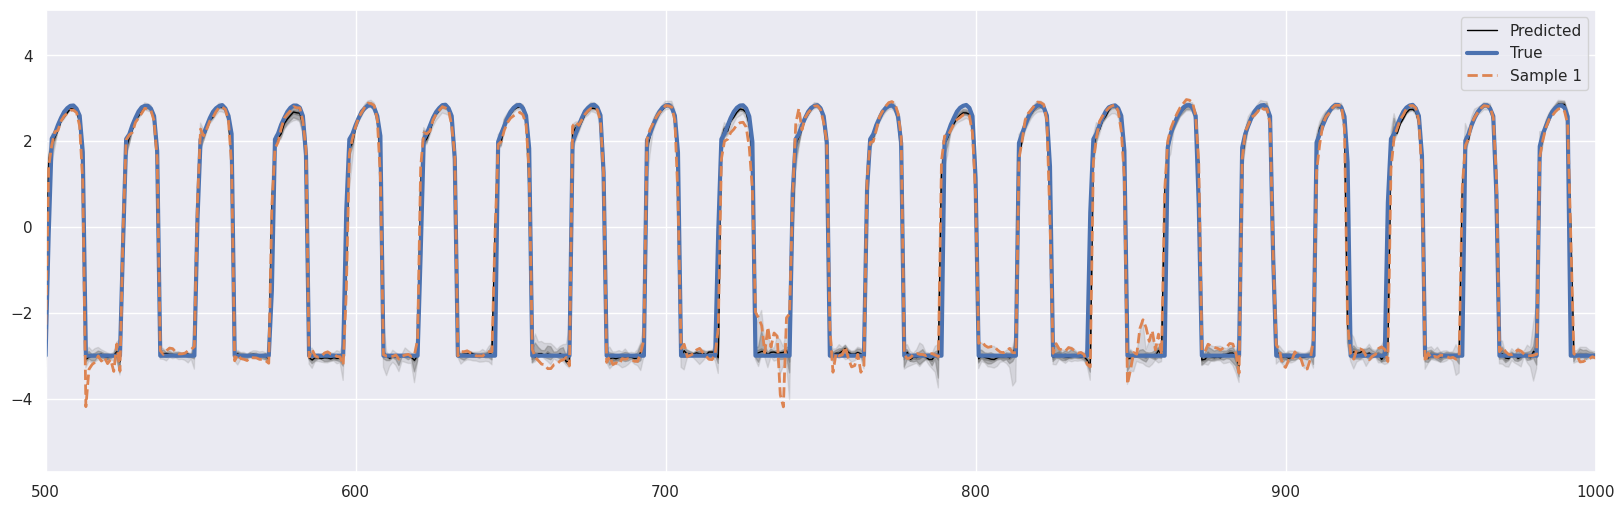

In [98]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(estimations_test[user_idx,:,quantiles.__len__()//2], label="Predicted", color="black", lw=1)
for i in range(quantiles.__len__()//2):
    ax.fill_between(np.arange(estimations_test.shape[1]), estimations_test[user_idx,:,i], estimations_test[user_idx,:,-(i+1)], alpha=2*quantiles[i], color="gray")

ax.plot(X_test.reshape(user_ids["train"][-1]+1,-1)[user_idx], label="True", lw=3)
ax.plot(estimations_test_[0,user_idx], label="Sample 1", lw=2, ls="--")
ax.legend()

plt.xlim(500, 1000)
plt.show()


In [73]:
def calculate_quantile_loss(predictions, targets, quantiles):
    """
    Calculate the average quantile loss for multiple quantiles.
    
    Parameters:
        predictions (torch.Tensor): Predicted quantiles with shape (batch_size, output_size, num_quantiles)
        targets (torch.Tensor): Actual target values with shape (batch_size, output_size)
        quantiles (list of float): List of quantiles

    Returns:
        float: The average quantile loss over the predictions
    """
    total_loss = 0.0
    batch_size = targets.size(0)
    
    for i, q in enumerate(quantiles):
        errors = targets - predictions[:, :, i]
        loss = torch.max((q - 1) * errors, q * errors).mean()
        total_loss += loss.item()
    
    return total_loss / len(quantiles)

In [74]:
calculate_quantile_loss(torch.tensor(estimations_test), torch.tensor(X_test.reshape(user_ids["train"][-1]+1,-1)), quantiles)

0.1527695120735273

In [87]:
## calculate rmse
def calculate_rmse(predictions, targets):
    """
    Calculate the root mean squared error between predictions and targets.
    
    Parameters:
        predictions (torch.Tensor): Predicted values
        targets (torch.Tensor): Actual target values

    Returns:
        float: The root mean squared error between predictions and targets
    """
    return torch.mean(torch.sqrt(torch.mean((predictions - targets) ** 2, dim=-1)), dim=-1)

In [88]:
calculate_rmse(torch.tensor(estimations_test.transpose(2,0,1)).float(), torch.tensor(X_test.reshape(user_ids["train"][-1]+1,-1)))

tensor([0.7157, 0.5974, 0.5448, 0.5342, 0.5429, 0.6007, 0.7545],
       dtype=torch.float64)

In [92]:
torch.sqrt(torch.mean( (torch.tensor(estimations_test_).float() - torch.tensor(X_test.reshape(user_ids["train"][-1]+1,-1)).unsqueeze(0))**2, dim=-1)).shape

torch.Size([10, 683])